<a href="https://colab.research.google.com/github/Lucas-Monteiro-Henriques/Implement_VISIONTS/blob/main/MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf /content/mae


In [ ]:
import sys
import os
import requests

import torch
import numpy as np
np.float = float

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
from models_mae import mae_vit_base_patch16
model = mae_vit_base_patch16()


Running in Colab.


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    from models_mae import mae_vit_base_patch16
    model = mae_vit_base_patch16()

    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch and send to GPU
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x).cuda()

    # run MAE
    with torch.no_grad():
        loss, y, mask = model(x.float(), mask_ratio=0.75)
        y = model.unpatchify(y)
        y = torch.einsum('nchw->nhwc', y).cpu()

        # process mask
        mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 * 3)
        mask = model.unpatchify(mask)
        mask = torch.einsum('nchw->nhwc', mask).cpu()

    x = x.cpu()
    x = torch.einsum('nchw->nhwc', x)

    im_masked = x * (1 - mask)
    im_paste = x * (1 - mask) + y * mask

    plt.rcParams['figure.figsize'] = [24, 24]
    plt.subplot(1, 4, 1); show_image(x[0], "original")
    plt.subplot(1, 4, 2); show_image(im_masked[0], "masked")
    plt.subplot(1, 4, 3); show_image(y[0], "reconstruction")
    plt.subplot(1, 4, 4); show_image(im_paste[0], "reconstruction + visible")
    plt.show()


/tmp/ipython-input-3-883145717.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


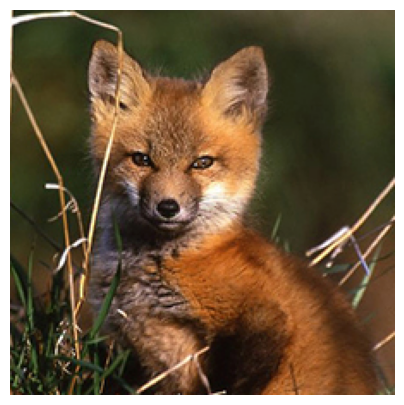

In [ ]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [ ]:
# MAE com decoder
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth


--2025-07-22 01:02:29--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.111, 13.35.37.84, 13.35.37.123, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447725789 (427M) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_base.pth’

mae_visualize_vit_b 100%[===================>] 426.98M  24.3MB/s    in 19s     

2025-07-22 01:02:49 (22.2 MB/s) - ‘mae_visualize_vit_base.pth’ saved [447725789/447725789]



In [ ]:
# Carrega o modelo base


from models_mae import mae_vit_base_patch16

chkpt_dir = 'mae_visualize_vit_base.pth'
model = mae_vit_base_patch16()
checkpoint = torch.load(chkpt_dir, map_location='cpu')
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

# Enviar para GPU
model.eval()
model.cuda()




<All keys matched successfully>


MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=768, out_features=512, bias=

MAE with pixel reconstruction:


/tmp/ipython-input-3-883145717.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


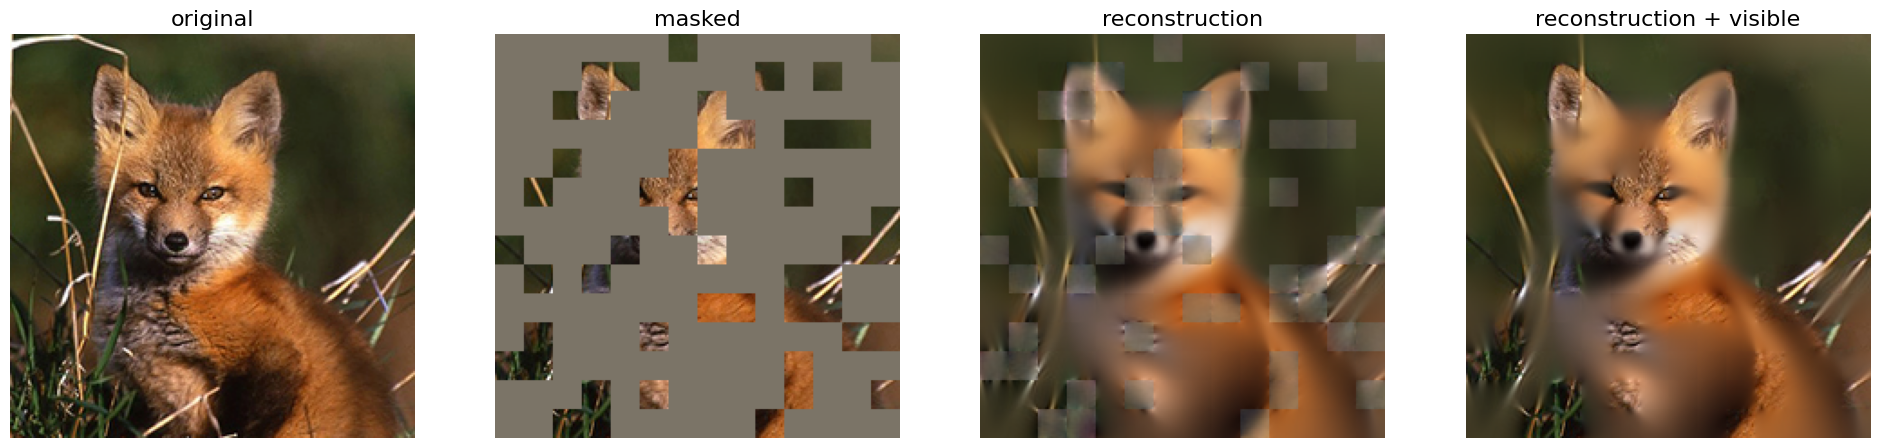

In [ ]:

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model)

Implementação do Algoritmo de transformação das séries temporais 1D para 2D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
import pandas as pd

df = pd.read_csv("https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTm1.csv")


serie = df["OT"].values[:512]

acf_vals = acf(serie, nlags=min(50, len(serie)//2), fft=True)

lags = np.arange(1, len(acf_vals))
acf_sem_lag0 = acf_vals[1:]
peaks, _ = find_peaks(acf_sem_lag0, height=0.2)

if len(peaks) == 0:
    P = 1
else:
    P = peaks[0] + 1

print(f"Periodicidade estimada: {P}")

L = (len(serie) // P) * P
serie_cortada = serie[:L]


matriz_2d = serie_cortada.reshape(P, L // P)
print("Matriz 2D:\n", matriz_2d)


Periodicidade estimada: 29
Matriz 2D:
 [[30.53100014 30.45999908 30.03800011 27.01300049 27.78700066 27.71699905
  27.64599991 27.08399963 27.78700066 27.50600052 27.85700035 27.01300049
  25.04400063 24.5510006  23.56599998 21.52599907 21.94799995]
 [21.45599937 22.79199982 21.0340004  21.17399979 20.82299995 21.17399979
  21.17399979 22.79199982 23.84799957 24.34000015 23.1439991  23.1439991
  23.77700043 23.84799957 23.98800087 21.66699982 22.0890007 ]
 [22.37000084 16.39100075 17.44599915 17.72699928 18.50099945 19.27499962
  19.97900009 18.50099945 18.5720005  19.41600037 20.11899948 19.76799965
  19.76799965 20.32999992 19.20499992 17.72699928 18.6420002 ]
 [18.50099945 18.5720005  19.6970005  19.55599976 19.83799934 19.55599976
  19.41600037 19.13400078 17.02400017 17.30500031 18.78300095 18.85300064
  19.20499992 19.48600006 19.62700081 18.43099976 19.76799965]
 [19.13400078 20.75200081 19.76799965 20.68199921 20.68199921 19.83799934
  19.20499992 19.41600037 18.71199989 17.868

Normalization do Iraw


In [6]:
import numpy as np
from statistics import mean
desvio_padrao = np.std(matriz_2d)
print(desvio_padrao)
mean  = np.mean(matriz_2d)
print(mean)

4.647547551956378
25.519399588780278


In [8]:
r = 0.4
Inorm = r * (matriz_2d - mean)/ desvio_padrao
print(Inorm)

[[ 0.43133291  0.42522207  0.38890193  0.1285496   0.19516539  0.18914057
   0.18302989  0.13466027  0.19516539  0.17098058  0.20119005  0.1285496
  -0.04091611 -0.0833471  -0.16812304 -0.34369959 -0.30737929]
 [-0.34972425 -0.23473884 -0.38604439 -0.37399508 -0.40420455 -0.37399508
  -0.37399508 -0.23473884 -0.14385221 -0.10150725 -0.20444335 -0.20444335
  -0.14996289 -0.14385221 -0.13180274 -0.3315641  -0.29524379]
 [-0.27105898 -0.78565297 -0.69485253 -0.67066772 -0.60405193 -0.53743613
  -0.476845   -0.60405193 -0.59794109 -0.52530064 -0.46479568 -0.49500515
  -0.49500515 -0.44663553 -0.54346079 -0.67066772 -0.59191643]
 [-0.60405193 -0.59794109 -0.50111583 -0.51325132 -0.48898049 -0.51325132
  -0.52530064 -0.54957147 -0.73117267 -0.70698786 -0.57978093 -0.57375628
  -0.54346079 -0.51927598 -0.50714048 -0.61007658 -0.49500515]
 [-0.54957147 -0.41031522 -0.49500515 -0.41634004 -0.41634004 -0.48898049
  -0.54346079 -0.52530064 -0.58589177 -0.65853222 -0.62823674 -0.60405193
  -0.6585

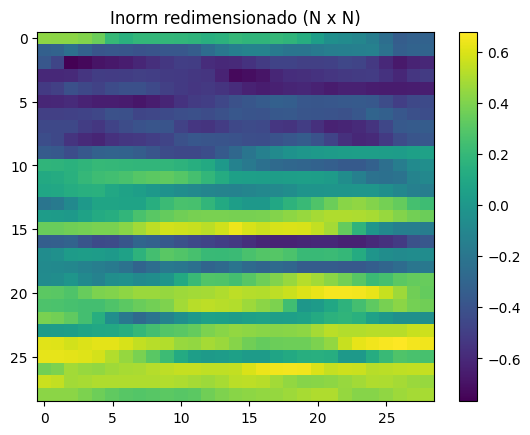

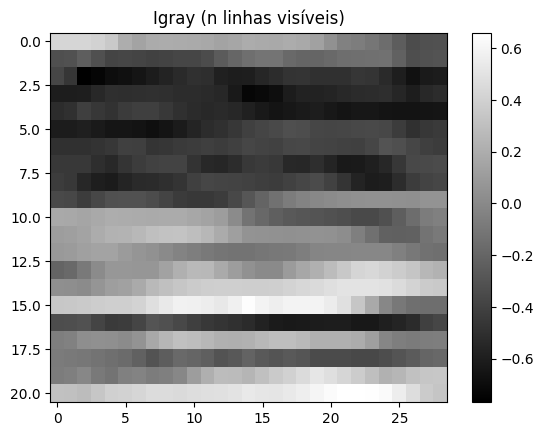

((21, 29), (21, 29, 3))

In [12]:

L = 300
H = 100
S = 1
N = max(Inorm.shape)
n = int(np.floor(N * L / (L + H)))


Inorm_resized = resize(Inorm, (N * S, N * S), order=1, mode='reflect', anti_aliasing=False)


Igray = Inorm_resized[:n * S, :N * S]
Igray_3ch = np.stack([Igray] * 3, axis=-1)  # shape (n, N, 3)

import matplotlib.pyplot as plt

plt.imshow(Inorm_resized, cmap='viridis', aspect='auto')
plt.title("Inorm redimensionado (N x N)")
plt.colorbar()
plt.show()

plt.imshow(Igray, cmap='gray', aspect='auto')
plt.title("Igray (n linhas visíveis)")
plt.colorbar()
plt.show()


Igray.shape, Igray_3ch.shape